In [106]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle

import itertools
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import log_loss, accuracy_score,f1_score, confusion_matrix

In [107]:
c_train = pd.read_csv("clean_train.csv")
c_test = pd.read_csv("clean_test.csv")

In [108]:
def label_encode(category):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(category)
    return integer_encoded

In [109]:
def one_hot(data):
    data = data.reshape(len(data), 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    data = onehot_encoder.fit_transform(data)
    return data

In [110]:
c_train['SexuponOutcome'] = c_train.IsAltered + c_train.Gender
c_test['SexuponOutcome'] = c_test.IsAltered + c_test.Gender

In [111]:
# Select features you want in model
wanted_features = ['AnimalType', 'SexuponOutcome', 'HasName', 'Year',
                  'Month', 'Day', 'Hour', 'DayofWeek',
                  'BreedType', 'CleanAge']

In [112]:
test = c_test[wanted_features]

In [113]:
# Encode all categorical data
test.AnimalType = label_encode(test.AnimalType)
#test.Gender = label_encode(test.Gender)
test.HasName = label_encode(test.HasName)
#test.IsAltered = label_encode(test.IsAltered)
test.BreedType = label_encode(test.BreedType)
test.SexuponOutcome = label_encode(test.SexuponOutcome)

C:\Users\jbsol\Anaconda3\envs\ipykernel_py3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [114]:
test.CleanAge = np.log(test.CleanAge+1)

C:\Users\jbsol\Anaconda3\envs\ipykernel_py3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [115]:
# Seperate labels from features.  Delete OutcomeSubtype
c_train = shuffle(c_train, random_state = 42)
labels = c_train.OutcomeType
features = c_train[wanted_features]

In [116]:
features.head()

,AnimalType,SexuponOutcome,HasName,Year,Month,Day,Hour,DayofWeek,BreedType,CleanAge
3197,Dog,AlteredFemale,True,2014,9,8,15,0,Mixed Breed,9.000000
17183,Cat,AlteredFemale,False,2014,11,25,18,1,Mixed Breed,0.250000
6235,Cat,UnknownUnknown,False,2014,3,6,14,3,Mixed Breed,0.666667
1968,Dog,AlteredFemale,True,2014,11,17,17,0,Mixed Breed,5.000000
23186,Cat,AlteredFemale,True,2014,4,13,12,6,Mixed Breed,11.000000


In [117]:
labels = label_encode(labels)

In [118]:
features.AnimalType = label_encode(features.AnimalType)
#features.Gender = label_encode(features.Gender)
features.HasName = label_encode(features.HasName)
#features.IsAltered = label_encode(features.IsAltered)
features.BreedType = label_encode(features.BreedType)
features.SexuponOutcome = label_encode(features.SexuponOutcome)
features.CleanAge = np.log(features.CleanAge + 1)

C:\Users\jbsol\Anaconda3\envs\ipykernel_py3\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [119]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=42)

In [120]:
# Run model if it exists
try:
    classifier_f = open("bag_log_reg.pickle", "rb")
    classifier = pickle.load(classifier_f)
    classifier_f.close()
    lrclf = classifier.best_estimator_
    print(classifier.best_params_)
    print(classifier.best_score_)
    print(lrclf)
    
except OSError:
    logreg = LogisticRegression(random_state = 1123)
    skb = SelectKBest(f_classif)

    pipeline = Pipeline(steps=[("SKB",skb),
                                   ("LR", logreg)])

    params = {'SKB__k':[8],
              'LR__C': [10]}

    split = StratifiedShuffleSplit(labels_train, test_size=0.25, random_state=42)

    gs = GridSearchCV(pipeline, params, cv = split, scoring = 'neg_log_loss')

    gs.fit(features_train,labels_train)
    lrclf=gs.best_estimator_
    print(gs.best_params_)
    print(gs.best_score_)
    print(lrclf)

    save_classifier = open("bag_log_reg.pickle","wb")
    pickle.dump(gs, save_classifier)
    save_classifier.close()

{'LR__C': 10, 'SKB__k': 8}
-0.906956603599
Pipeline(memory=None,
     steps=[('SKB', SelectKBest(k=8, score_func=<function f_classif at 0x0000021DC9A98048>)), ('LR', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [121]:
#print(classifier.best_estimator_.named_steps['SKB'].get_support())
print(classifier.best_estimator_.named_steps['LR'].coef_)

[[ -2.20e-01  -1.21e+00   7.83e-01  -5.63e-04   1.42e-01   1.36e-01
   -1.42e-01  -1.06e+00]
 [ -3.53e-01   5.91e-01  -1.83e-01  -1.92e-03  -1.22e-01   3.22e-03
    3.36e-02  -2.91e-01]
 [ -7.80e-02   5.30e-01  -1.07e+00  -1.97e-03  -4.75e-03  -7.67e-02
    2.27e-01   1.15e+00]
 [  1.48e+00   1.26e-01   2.02e+00  -3.15e-03   5.42e-02  -5.58e-02
    2.12e-01   9.88e-01]
 [ -4.72e-01   6.24e-01  -9.01e-01   9.72e-04  -1.47e-01  -7.84e-02
   -5.04e-03  -1.80e-01]]


In [122]:
try:
    classifier_f = open("rf.pickle", "rb")
    classifier = pickle.load(classifier_f)
    classifier_f.close()
    
    rfclf = classifier.best_estimator_
    print(classifier.best_params_)
    print(classifier.best_score_)
    print(rfclf)
except OSError:
    rf = RandomForestClassifier(random_state=1122)
    skb = SelectKBest(f_classif)

    pipeline = Pipeline(steps=[("SKB",skb),
                                   ("RF", rf)])

    params = {'SKB__k':[9],'RF__n_estimators': [500],'RF__min_samples_leaf': [10]}

    split = StratifiedShuffleSplit(labels_train, test_size=0.25, random_state=42)

    gs = GridSearchCV(pipeline, params, cv = split, scoring = 'neg_log_loss')

    gs.fit(features_train,labels_train)
    rfclf=gs.best_estimator_
    print(gs.best_params_)
    print(gs.best_score_)
    print(rfclf)

    save_classifier = open("rf.pickle","wb")
    pickle.dump(gs, save_classifier)
    save_classifier.close()

{'RF__min_samples_leaf': 10, 'RF__n_estimators': 500, 'SKB__k': 9}
-0.784364769068
Pipeline(memory=None,
     steps=[('SKB', SelectKBest(k=9, score_func=<function f_classif at 0x0000021DC9A98048>)), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=...n_jobs=1,
            oob_score=False, random_state=1122, verbose=0,
            warm_start=False))])


In [123]:
#print(classifier.best_estimator_.named_steps['SKB'].get_support())
print(classifier.best_estimator_.named_steps['RF'].feature_importances_ )

[ 0.05  0.3   0.1   0.02  0.05  0.15  0.06  0.01  0.25]


In [124]:
try:
    classifier_f = open("xgb.pickle", "rb")
    classifier = pickle.load(classifier_f)
    classifier_f.close()
    
    xgclf = classifier.best_estimator_
    print(classifier.best_params_)
    print(classifier.best_score_)
    print(xgclf)
except OSError:
    xgbc = XGBClassifier(random_state = 1123)
    skb = SelectKBest(f_classif)

    pipeline = Pipeline(steps=[("SKB",skb), ("XGB", xgbc)])

    params = {'SKB__k':[10],
              'XGB__max_depth': [7],
              'XGB__min_child_weight':[4],
              #'XGB__gamma':[0.1]
             }

    split = StratifiedShuffleSplit(labels_train, test_size=0.25, random_state=42)

    gs = GridSearchCV(pipeline, params, cv = split, scoring = 'neg_log_loss')

    gs.fit(features_train,labels_train)
    xgclf=gs.best_estimator_
    print(gs.best_params_)
    print(gs.best_score_)
    print(xgclf)

    save_classifier = open("xgb.pickle","wb")
    pickle.dump(gs, save_classifier)
    save_classifier.close()

{'SKB__k': 10, 'XGB__max_depth': 7, 'XGB__min_child_weight': 4}
-0.763625983395
Pipeline(memory=None,
     steps=[('SKB', SelectKBest(k=10, score_func=<function f_classif at 0x0000021DC9A98048>)), ('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=4, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=1123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])


In [125]:
print(classifier.best_estimator_.named_steps['XGB'].feature_importances_ )

[ 0.05  0.05  0.03  0.06  0.14  0.2   0.18  0.1   0.02  0.17]


In [127]:
predict1 = lrclf.predict_proba(test)
predict2 = xgclf.predict_proba(test)
predict3 = rfclf.predict_proba(test)
final_prediction = (predict3 + predict2)/2

In [128]:
c_predict_rf = rfclf.predict(features_test)
c_predict_xgb = xgclf.predict(features_test)

In [138]:
c_predict_ensemble = (rfclf.predict_proba(features_test) + xgclf.predict_proba(features_test))/2
c_predict_ensemble = np.argmax(c_predict_ensemble, axis=1)

In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [57]:
cnf_matrix_rf = confusion_matrix(labels_test, c_predict_rf)
np.set_printoptions(precision=2)

In [58]:
cnf_matrix_xgb = confusion_matrix(labels_test, c_predict_xgb)
np.set_printoptions(precision=2)

In [97]:
cnf_matrix_ensemble = confusion_matrix(labels_test, c_predict_ensemble)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[1838    0    1  202  129]
 [   5    0    0    2   25]
 [  58    0   56   69  130]
 [ 407    0    0  442  104]
 [ 354    0   12  166 1346]]


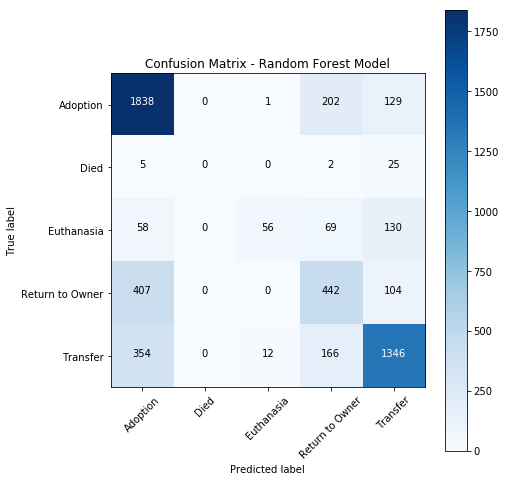

In [64]:
plot_confusion_matrix(cnf_matrix_rf, 
                      classes=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],
                      normalize=False,
                      title = "Confusion Matrix - Random Forest Model")

Confusion matrix, without normalization
[[1823    0    4  211  132]
 [   6    5    2    2   17]
 [  50    0   82   67  114]
 [ 385    0    6  456  106]
 [ 325    2   40  171 1340]]


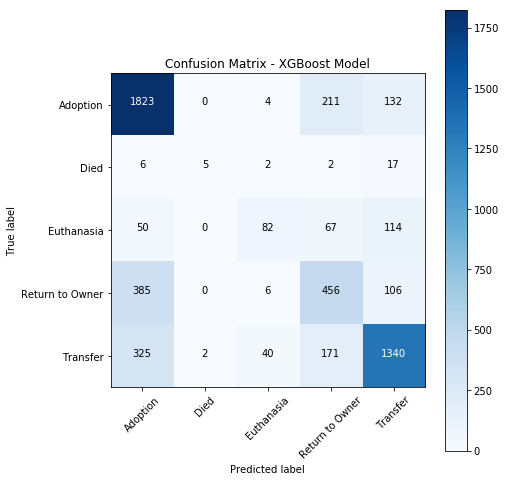

In [66]:
plot_confusion_matrix(cnf_matrix_xgb,
                      classes=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],
                      normalize=False,
                      title = 'Confusion Matrix - XGBoost Model')

Confusion matrix, without normalization
[[1834    0    3  199  134]
 [   6    2    1    2   21]
 [  57    0   67   66  123]
 [ 410    0    3  438  102]
 [ 331    0   24  172 1351]]


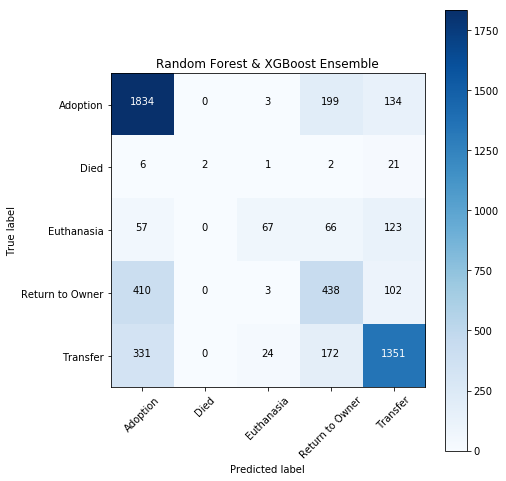

In [102]:
plot_confusion_matrix(cnf_matrix_ensemble, 
                      classes=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],
                      normalize=False,
                      title = "Random Forest & XGBoost Ensemble")

In [82]:
output = pd.DataFrame(final_prediction,columns=['Adoption','Died','Euthanasia','Return_to_owner','Transfer'])
output.index.names = ['ID']
output.index += 1
output['ID'] = output.index
output.to_csv('predictions.csv', columns = ['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer'], index = False)